In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as smf

# Linear Regression (Jan, Tim)

### 1. Import data and merge the weather data with the bicycle dataset for both cities

In [2]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

In [3]:
marburg_weather["h"]= marburg_weather.index
marburg["h"]=marburg.index.floor(freq='h')
marburgWeather = pd.merge(marburg, marburg_weather, how='right', left_on='h', right_on='h')

duisburg_weather["h"]= duisburg_weather.index
duisburg["h"]=duisburg.index.floor(freq='h')
duisburgWeather = pd.merge(duisburg, duisburg_weather, how='right', left_on='h', right_on='h')

We now have the temperature data available for every single ride.

### 2. Define independent and dependent variables

Because we want to see how the temperature affects the bicycle demand, we want to define the demand (the number of bicycles rented during each hour) as our dependent variable (y) and the temperature for each hour as our independent variable (x).

Let us start with the Marburg data:

In [10]:
ym = marburgWeather.resample('H', on="h").count()["day"].values
xm = marburgWeather.resample('H', on="h").max()['temperature'].values.reshape(-1,1)

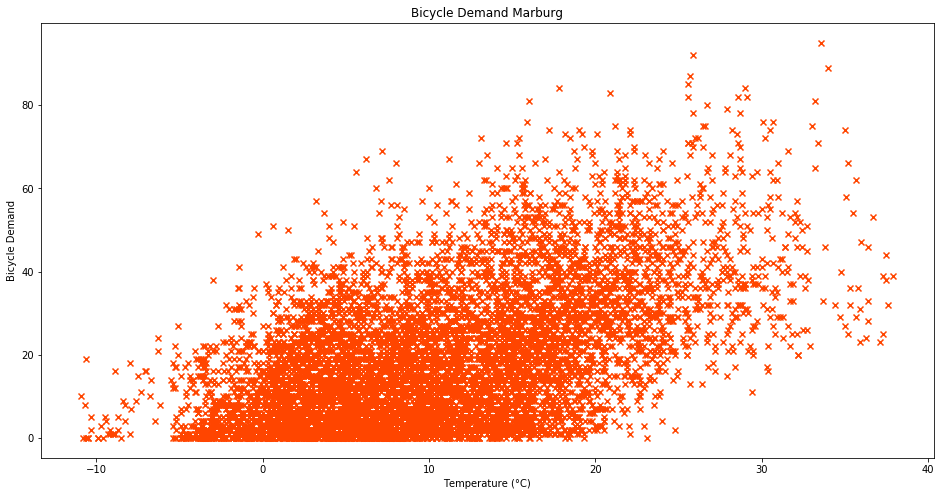

In [11]:
plt.figure(figsize = (16,8))
plt.scatter (xm, ym, marker = 'x', color = 'orangered')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bicycle Demand")
plt.title("Bicycle Demand Marburg")
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

### 3. Train / Test split

We split the data into a training and testing set, to better evaluate the model.

In [12]:
xm_train, xm_test, ym_train, ym_test = train_test_split(xm, ym, test_size=0.3, random_state=0)

### 4. Initialize linear model with scikit-learn

In [13]:
linear_model_mar = LinearRegression()

### 5. Fit the model

We train our linear modell with the training data.

In [14]:
linear_model_mar.fit(xm_train,ym_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 6. Predict training data

Here we make predicitions with the .predict() function on our testing set.

In [15]:
y_pred_m = linear_model_mar.predict(xm_test)

### 7. Define y true

In [16]:
y_true_m = ym_test

### 8. Plot the linear model

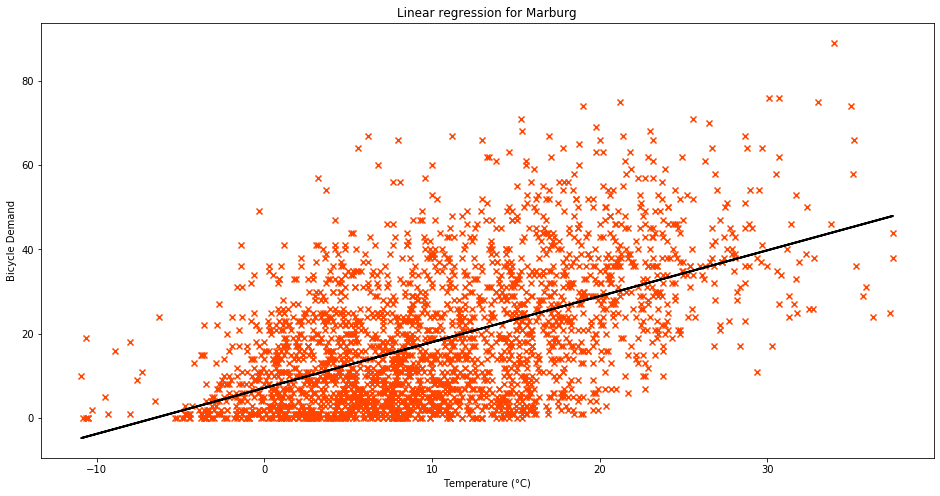

In [18]:
plt.figure(figsize = (16,8))

plt.scatter(xm_test, ym_test, marker="x", color = 'orangered')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bicycle Demand")
plt.title("Linear regression for Marburg")

plt.plot(xm_test, y_pred_m, color = 'black', linewidth = 2)

xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

### 9. Present test metrics

Here we are evaluating our model with the Mean Absolute Error, the Mean Squared Error and the R^2 score.

In [19]:
print("Mean Absolute Error Marburg:",mean_absolute_error(y_true_m, y_pred_m),"Bicycles")
print("Mean Squared Error Marburg:",mean_squared_error(y_true_m, y_pred_m),"Bicycles")
print("Coefficient of determination Marburg:",r2_score(y_true_m, y_pred_m))

Mean Absolute Error Marburg: 10.556477708444188 Bicycles
Mean Squared Error Marburg: 177.54667444856273 Bicycles
Coefficient of determination Marburg: 0.2775329354520205


As you can see, the error metrics for our linear model are relatively bad, with a high MAE and MSE and a low R^2 Score (the R^2 Score lies between 0 and 1, with a higher score signifying a better model).

### Linear regression for duisburg

Let us quickly repeat this process for the Duisburg dataset.

In [20]:
yd = duisburgWeather.resample('H', on="h").count()["day"].values

xd = duisburgWeather.resample('H', on="h").max()['temperature'].values.reshape(-1,1)

xd_train, xd_test, yd_train, yd_test = train_test_split(xd, yd, test_size=0.3, random_state=0)

linear_model_dui = LinearRegression()

linear_model_dui.fit(xd_train,yd_train)

y_pred_d = linear_model_dui.predict(xd_test)

y_true_d = yd_test

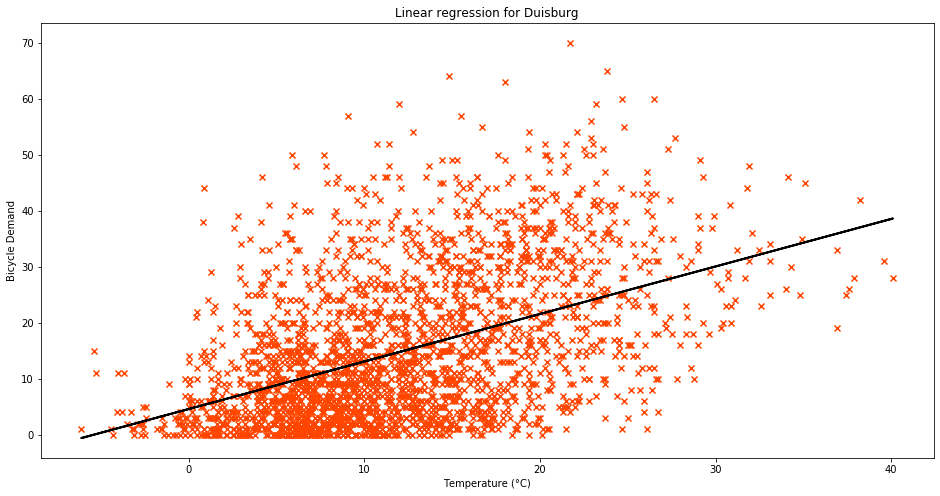

In [22]:
plt.figure(figsize = (16,8))

plt.scatter(xd_test, yd_test, marker="x", color = 'orangered')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bicycle Demand")
plt.title("Linear regression for Duisburg")

plt.plot(xd_test, y_pred_d, color = 'black', linewidth = 2)

xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [23]:
print("Mean Absolute Error Duisburg:",mean_absolute_error(y_true_d, y_pred_d),"Bicycles")
print("Mean Squared Error Duisburg:",mean_squared_error(y_true_d, y_pred_d),"Bicycles")
print("Coefficient of determination Duisburg:",r2_score(y_true_d, y_pred_d))

Mean Absolute Error Duisburg: 9.085832555452141 Bicycles
Mean Squared Error Duisburg: 133.09099774615393 Bicycles
Coefficient of determination Duisburg: 0.21883681940409405


If we compare the test of Duisburg to those of Marburg we can observe smaller errors but a lower Coefficient of Determination.

# Multiple linear regression

Here we are adding multiple features to our linear regression to see if it improves the performance of our model. We are starting with the Marburg data again.

We are adding another column "IsWeekday" to our data, that has the value 1 if the ride took place on a weekday and 0 if it happened on a weekend day.

In [24]:
def weekday_check (dt):
    day_count = dt.weekday()
    if day_count <=4:
        return 1
    else:
        return 0

marburgWeather["IsWeekday"] = marburgWeather["day"].apply(weekday_check)
marburgWeather.head(5)

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,h,temperature,precipitation,IsWeekday
0,2019-07-04,13:29:00,11070.0,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3.0,13.0,41.0,2019-07-04 13:00:00,23.8,0.0,1
1,2019-07-04,13:48:00,11073.0,marburg,"(50.811, 8.7742)","(50.8167, 8.7812)",3.0,13.0,33.0,2019-07-04 13:00:00,23.8,0.0,1
2,2019-07-04,13:38:00,11076.0,marburg,"(50.7988, 8.7621)","(50.8229, 8.7747)",3.0,13.0,49.0,2019-07-04 13:00:00,23.8,0.0,1
3,2019-07-04,13:35:00,11080.0,marburg,"(50.8136, 8.7734)","(50.82, 8.7737)",3.0,13.0,15.0,2019-07-04 13:00:00,23.8,0.0,1
4,2019-07-04,13:54:00,11087.0,marburg,"(50.8229, 8.7747)","(50.811, 8.7742)",3.0,13.0,18.0,2019-07-04 13:00:00,23.8,0.0,1


### Creating a new dataframe with all the features we need for our multiple linear regression 
(Temperature, Demand, Precipitation and IsWeekday).

In [25]:
MulRegMar = pd.DataFrame()
MulRegMar["temperature"] = marburgWeather.resample('H', on="h").max()['temperature'].values#.reshape(-1,1)
MulRegMar["IsWeekday"] = marburgWeather.resample('H', on="h").max()["IsWeekday"].values
MulRegMar["Demand"] = marburgWeather.resample('H', on="h").count()["day"].values
MulRegMar["precipitation"] = marburgWeather.resample('H', on="h").max()['precipitation'].values
MulRegMar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    8784 non-null   float64
 1   IsWeekday      8784 non-null   int64  
 2   Demand         8784 non-null   int64  
 3   precipitation  8784 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 274.6 KB


### Define variables, split data set, fit model, predict value

Next, we define our dependent (ym2, "Demand") and independent (Xm2, "Temperature", "Precipitation" and "IsWeekday") variables.
Then we split the data into training and testing sets, fit the model with the training data and predict our values with the testing set.

In [26]:
Xm2 = MulRegMar[["temperature", "IsWeekday", "precipitation"]]
ym2 = MulRegMar["Demand"]
xm2_train, xm2_test, ym2_train, ym2_test = train_test_split(Xm2, ym2, test_size=0.3, random_state=0)
lin_mod_mul_m = LinearRegression()
lin_mod_mul_m.fit(xm2_train, ym2_train)
y_pred_m2 = lin_mod_mul_m.predict(xm2_test)
y_true_m2 = ym2_test
print(lin_mod_mul_m.coef_, lin_mod_mul_m.intercept_)

[ 1.07005128  7.7441392  -3.22738219] 2.332647663514802


### Plot the regression

Text(0.5, 0, 'Demand')

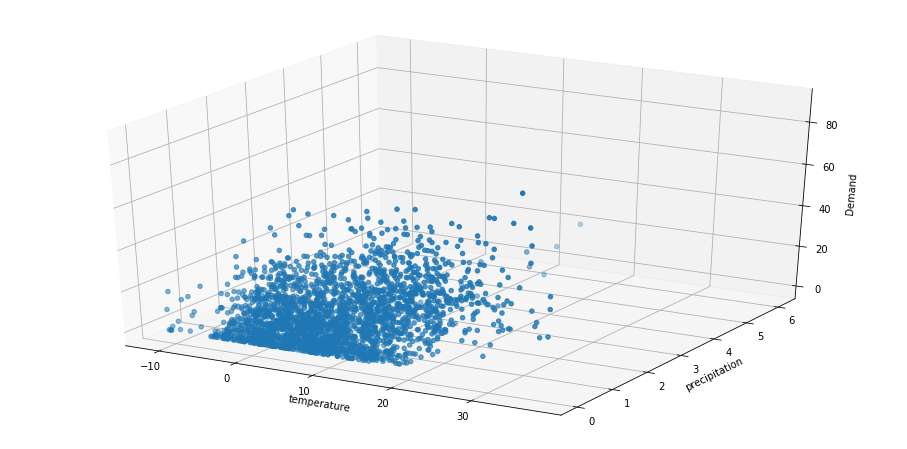

In [28]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xm2_test["temperature"], xm2_test["precipitation"], ym2_test)
ax.set_xlabel('temperature')
ax.set_ylabel('precipitation')
ax.set_zlabel('Demand')

### Evaluate the test metrics

Test metrics for one-dimensional vs. two-dimensional linear regression for Marburg:

In [29]:
print("MAE Marburg:",mean_absolute_error(y_true_m2, y_pred_m2),"Bicycles")
print("MSE Marburg:",mean_squared_error(y_true_m2, y_pred_m2),"Bicycles")
print("R^2 Marburg:",r2_score(y_true_m2, y_pred_m2))

MAE Marburg: 10.113031936061812 Bicycles
MSE Marburg: 163.05802930264926 Bicycles
R^2 Marburg: 0.33648965182170953


## Multiple linear regression for Duisburg

We proceed analogously for the Duisburg data set

In [30]:
duisburgWeather["IsWeekday"] = duisburgWeather["day"].apply(weekday_check)
MulRegDui = pd.DataFrame()
MulRegDui["temperature"] = duisburgWeather.resample('H', on="h").max()['temperature'].values
MulRegDui["IsWeekday"] = duisburgWeather.resample('H', on="h").max()["IsWeekday"].values
MulRegDui["precipitation"] = duisburgWeather.resample('H', on="h").max()['precipitation'].values
MulRegDui["Demand"] = duisburgWeather.resample('H', on="h").count()["day"].values
Xd2 = MulRegDui[["temperature", "IsWeekday", "precipitation"]]
yd2 = MulRegDui["Demand"]
xd2_train, xd2_test, yd2_train, yd2_test = train_test_split(Xd2, yd2, test_size=0.3, random_state=0)
lin_mod_mul_d = LinearRegression()
lin_mod_mul_d.fit(xd2_train, yd2_train)
y_pred_d2 = lin_mod_mul_d.predict(xd2_test)
y_true_d2 = yd2_test

print(lin_mod_mul_m.coef_, lin_mod_mul_m.intercept_)

[ 1.07005128  7.7441392  -3.22738219] 2.332647663514802


Test metrics for one-dimensional vs. two-dimensional linear regression for Duisburg:

In [31]:
print("MAE Duisburg:",mean_absolute_error(y_true_d2, y_pred_d2),"Bicycles")
print("MSE Duisburg:",mean_squared_error(y_true_d2, y_pred_d2),"Bicycles")
print("R^2 Duisburg:",r2_score(y_true_d2, y_pred_d2))

MAE Duisburg: 8.474142506242488 Bicycles
MSE Duisburg: 117.08844267374474 Bicycles
R^2 Duisburg: 0.31276208129045313
